# 1. Zadaća - Filip Skrinjar
## Pregled nekih algoritama strojnog učenja
### 1) Linearna regresija  

Kako bi demonstrirali neke algoritme strojnog učenja koristit ćemo podatke sa Quandl repozitorija. Da bi mogli koristiti Quandl u pythonu potrebno nam je bilo instlairati njihov paket te onda možemo preuzimati podatke od njih direktno bez dodatnih datoteka.

In [1]:
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
podatci = quandl.get("LME/PR_CO", authtoken="Bygw8KP9XWpisC6gGapq") #cijene kobalta
podatci.columns

Index(['Cash Buyer', 'Cash Seller & Settlement', '3-months Buyer',
       '3-months Seller', '15-months Buyer', '15-months Seller'],
      dtype='object')

naredbom quandl.get smo preuzeli podatke naziva LME/PR_CO što nam označava da preuzeli cijene kobalta sa Londonske burze metala. 

In [2]:
podatci.head()

,Cash Buyer,Cash Seller & Settlement,3-months Buyer,3-months Seller,15-months Buyer,15-months Seller
Date,,,,,,
2012-01-03,29750.0,30350.0,29500.0,30100.0,28375.0,29375.0
2012-01-04,31500.0,32000.0,31250.0,31750.0,30075.0,31075.0
2012-01-05,32350.0,32500.0,31500.0,32000.0,30330.0,31330.0
2012-01-06,32250.0,32700.0,31000.0,32000.0,30075.0,31075.0
2012-01-09,31800.0,32300.0,31300.0,31800.0,30125.0,31125.0


Vidimo da su vrijednosti poprilično velike, a mjerenja su od 2012 godine, pa ako ne obradimo podatke unaprijed onda će nam to stvarati numeričke probleme kod naših algoritama.

In [3]:
podatci.mean()

Cash Buyer                  34746.536260
Cash Seller & Settlement    35258.597328
3-months Buyer              34705.607506
3-months Seller             35314.745547
15-months Buyer             34614.847964
15-months Seller            35614.847964
dtype: float64

Jedan od najpopularnijih načina reskaliranja podataka je da ga normaliziramo sa očekivanjem 0. Naime to neće promjeniti strukturu podataka a sve vrijednosti će biti dovoljno malene po apsolutnoj vrijednosti

In [4]:
podatci = podatci - podatci.mean()
podatci = podatci / podatci.max()
podatci.head()

,Cash Buyer,Cash Seller & Settlement,3-months Buyer,3-months Seller,15-months Buyer,15-months Seller
Date,,,,,,
2012-01-03,-0.082925,-0.081482,-0.086337,-0.086645,-0.103764,-0.103764
2012-01-04,-0.053881,-0.054092,-0.057312,-0.059230,-0.075494,-0.075494
2012-01-05,-0.039774,-0.045792,-0.053166,-0.055076,-0.071254,-0.071254
2012-01-06,-0.041434,-0.042472,-0.061459,-0.055076,-0.075494,-0.075494
2012-01-09,-0.048902,-0.049112,-0.056483,-0.058399,-0.074663,-0.074663


promatrati ćemo stupac Cash Buyer te ćemo pogledati kako razlićiti regresijski modeli opisuju kretanje cijena kobalta

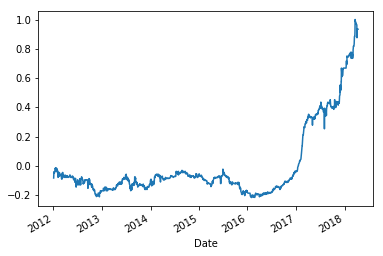

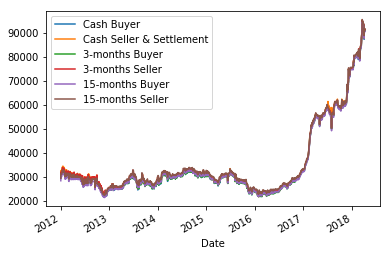

In [5]:
cijena = podatci["Cash Buyer"].as_matrix(columns= None)  #y vrijednosti

podatci["Cash Buyer"].plot()
quandl.get("LME/PR_CO", authtoken="Bygw8KP9XWpisC6gGapq").plot()

vidimo da naši podatci, iako su reskalirani, zadržavaju strukturu početnih podataka

In [6]:
print( "standardna devijacija: ",podatci["Cash Buyer"].std() , " medijan : ",podatci["Cash Buyer"].median() ) 

standardna devijacija:  0.25210482220362335  medijan :  -0.08707443412948769


In [7]:
print("25%-tni kvantil: ",podatci["Cash Buyer"].quantile(0.25) , "\n75%-tni kvantil: ",podatci["Cash Buyer"].quantile(0.75)) 

25%-tni kvantil:  -0.13686410286824285 
75%-tni kvantil:  -0.04558304351385839


In [8]:
podatci["Cash Buyer"].skew()

1.98625861858205

Pozitivni skew nam govori da je desna rep podataka ili deblji ili duži, što vidimo i iz grafa. 

Također, odmah vidimo da regresija pravcem nece dobro opisivati podatke jer je cijena skoro stalno rasla od 2017 godine. Ali svejedno ćemo napraviti i regresiju pravcem jer ćemo je uspoređivati kasnije sa drugima

In [9]:
X = np.c_[np.ones(len(cijena)) , range(len(cijena)) ]
initTheta = np.array([0,0])

za računanje koeficjenata našeg modela trebati će nam dvije funkcije, jedna koja će računati koliko naš model dobro opisuje podatke koristeći srednju vrijednost kvadratnog odstupanja (MSE) , a druga će biti funkcija koja će gradijentnim spustom izračunati optimalnu vrijednost našeg parametra

In [10]:
def LinRegComputeCost(X ,y ,theta ):
    m = len(y)
    h = np.dot(X, theta)
    J = (1/(2*m)) * np.sum(np.power(h-y,2))
    return J

In [11]:
def gradientDescent(X, y, theta, alpha, num_iters):
    m = len(y)
    J_povijest = np.zeros(num_iters)
    for i in range(0, num_iters):
        h = np.dot(X,theta)
        grad = np.dot(X.transpose(), h-y)/m
        theta = theta - alpha*grad
        J_povijest[i] = LinRegComputeCost(X ,y ,theta)
    return theta, J_povijest   

Za linearnu regresiju potrebno nam je odjeliti naša mjerina u 2 skupa, jedan skup je za treniranje parametara modela a drugi skup je za testiranje. Standardna praksa je uzeti 70% za treniranje a 30 % za testiranje

In [12]:
br_iteracija = 1500
X_train = X[ :int(0.7*len(X)), : ]  #prvih 70%
X_test = X[int(0.7*len(X)):, : ]
y_train = cijena[ :int(0.7*len(cijena))]  
y_test = cijena[ int(0.7*len(cijena)): ]

nakon pripreme, možemo dati podatke u funkciju gradijentnog spusta te ćemo pratiti kako nam se kreću funckije cijene dok tražimo naše parametre. Potom ćemo moći koristiti tu funkciju cijene kao pokazatelj da li nam algoritam dobro funkcionira. Za koeficjent $alpha$ uzet ćemo 0.00000495 jer svaki veći broj izazove overflow.

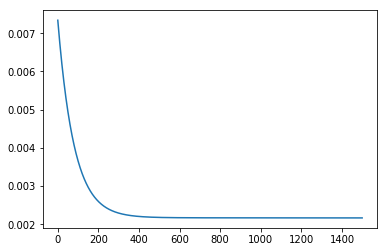

In [13]:
optimal_theta, J_history = gradientDescent(X_train, y_train, initTheta, 0.00000495, br_iteracija)
plt.plot(J_history)
plt.show()

vidimo da smo gradijentnim spustom našli približno optimalno rješenje. Pogledajmo koliko dobro naš model opisuje nas skup za treniranje

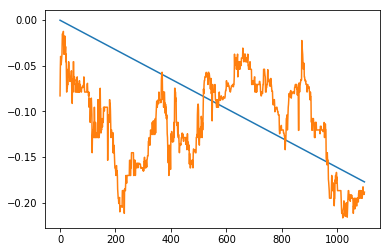

In [14]:
fig1, ax1 = plt.subplots()
ax1.plot(X_train[:,1], np.matmul(X_train,optimal_theta))
ax1.plot(X_train[:,1], y_train)

Uzimajući u obzjer velike oscilacije u podatcima izgleda dosta dobro. no pogledajmo kako se pravac ponaša na testnom skupu

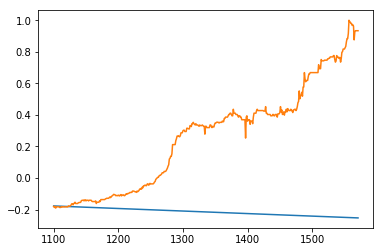

In [15]:
plt.plot(X_test[:,1], np.matmul(X_test,optimal_theta))
plt.plot(X_test[:,1], y_test)

Na testnom skupu naš pravac _nimalo_ ne opisuje podatke! Zašto ? Zbog toga što smo naše podatke particionirali na prvih 70% i na zadnjih 30%. No naši podatci imaju veliki _skew_ pa je rep podataka upao *samo* u testni dio podataka. Pametnije particioniranje skupa podataka je da ne uzimamo prvih 70% i zadnjih 30% nego da odaberemo nasumično 70% za treniranje i 30% za test. To možemo napraviti tako da koristimo permutacije

In [16]:
def particioniranje(X,y):
    m = X.shape[1]
    Xy = np.c_[X , y]
    Xyperm = np.random.permutation(Xy)
    X_train = Xyperm[ :int(0.7*len(X)), :m ]  #prvih 70%
    X_test = Xyperm[ int(0.7*len(X)):, :m ]
    y_train = Xyperm[ :int(0.7*len(X)), m ]  
    y_test = Xyperm[ int(0.7*len(X)):, m ]
    return X_train, X_test, y_train, y_test

In [17]:
X2_train, X2_test, y2_train, y2_test = particioniranje(X, cijena)
optimal_theta2, J_history2 = gradientDescent(X2_train, y2_train, initTheta, 0.000002, br_iteracija)
optimal_theta2, J_history2[-1]

(array([-2.03407388e-04,  8.69224265e-05]), 0.02854391448281792)

korištenjem pametnije podjele podataka na skupove za treniranje i testiranje dobili smo nove vrijednosti parametara modela. Pogledajmo kako naš novi pravac opisuje podatke

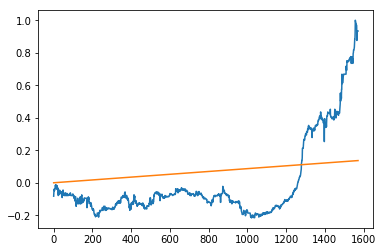

In [18]:
fig2, ax2 = plt.subplots()
ax2.plot(X[:,1], cijena)
ax2.plot(X[:,1], np.dot(X,optimal_theta2))

ne opisuje baš dobro, ali idemo vidjeti da li smo dobili kakav napredak u odnosu na prvi pravac 

In [19]:
LinRegComputeCost(X,cijena,optimal_theta) - LinRegComputeCost(X,cijena,optimal_theta2) 

0.025526123848209844

razlika je mala, no razlog tome je najviše to što dani podatci nisu prikladni za regresiju pravcem. zato nastavljamo sa polinomijalnom regresijom, konkretnije idemo probati opisati naše podatke sa polinomom drugog stupnja 

In [20]:
tempsqr = np.power(range(len(cijena)),2)
Xsqr = np.c_[X , tempsqr]
initTheta= np.array([0,0,0])
Xsqr_train, Xsqr_test, y_train, y_test = particioniranje(Xsqr, cijena)
optimal_theta3, J_history3 = gradientDescent(Xsqr_train, y_train, initTheta, 0.000000000001, br_iteracija)
optimal_theta3

array([-1.43757868e-10, -5.92546130e-08,  1.17784410e-07])

dobili smo slobodni koeficjent, parametar uz linearni član te parametar uz kvadratni član. pogeldajmo da li nam gradijentni spust radi dobro

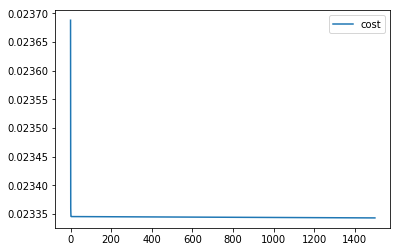

In [21]:
plt.plot(J_history3, label="cost")    
plt.legend()

čini se da radi jako dobro, cijena prakticki odmah padne u optimalno stanje. Pogledajmo kako izgleda naša parabola na podatcima

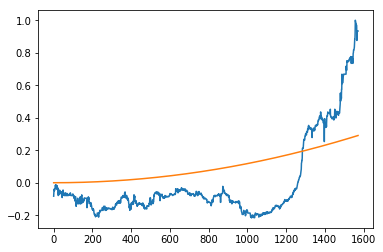

In [22]:
fig3, ax3 = plt.subplots()
ax3.plot(X[:,1], cijena)
ax3.plot(X[:,1], np.dot(Xsqr,optimal_theta3))

iako po grafu kretanja cijene funkcije izgleda kao da nas je gradijentni spust doveo priblizno blizu lokalnog optimuma, vidimo da naša krivulja ne opisuje dobro podatke kao što bi mogli očekivati. glavni razlog tome je jako mali parametar alpha kojeg smo morali koristiti, naime $alpha$ = 0.000000000001 kod gradijentnog spusta što znači da se naš algoritam spušta jako polako. Idemo zato pogeldati plohu funkcije cijene u ovisnosti o parametru $theta$ da dobijemo bolju ideju oko toga kako izgleda funkcija na kojoj provodimo algoritam

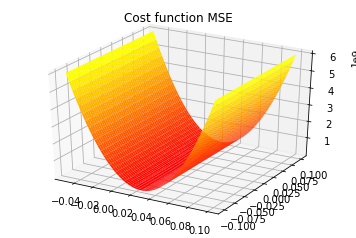

In [24]:
%matplotlib agg
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
thetax, thetay = np.meshgrid( np.linspace(-0.05,0.1,300), np.linspace(-0.1,0.1,300) ) 
cost = np.zeros((300,300))
for i in range(0,300):
    for j in range(0,300):
      cost[i,j] = LinRegComputeCost(Xsqr_train, y_train, np.array([0, thetax[0][i], thetay[j][0]])) 
  

ax.plot_surface(thetax, thetay, cost, cmap=cm.autumn, linewidth=1)
ax.set_title('Cost function MSE')
fig

vidimo da je naša vrijednost za parametar $theta$ ~ (-1.4e-10, -5.9e-08,  1.1e-07) koju smo našli gradijentnim spustom stvarno dobra aproksimacija lokalnog optimuma, samo što su podatci takvi da mala promjena u veličini parametara uvelike utječe na rast cijene, razlog tome je naravno veliki broj mjerenja. 

obzjerom da prevelik broj podataka stvara probleme kod računanja, jedno od mogućih rješenja je smanjivanje podataka. naime naša mjerenja su na dnevnoj bazi te zato svako pojedino mjerenje ne mijenja previše globalno stanje cijene, dakle da izbacivanjem nekih mjerenja nebi se trebala uvelike narušiti krivulja kretanja cijena pa mozemo pretpostaviti da ce model istreniran na manjem skupu podataka dobro opisivati i veći skup podataka 

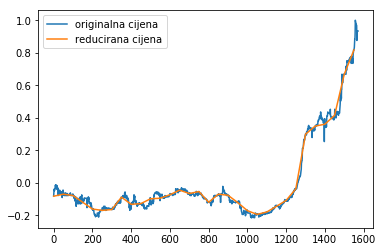

In [25]:
redCijena = cijena[0::50]
figUsporedba, axUsporedba = plt.subplots()
axUsporedba.plot(range(cijena.size),cijena, label="originalna cijena")
axUsporedba.plot(np.multiply(range(redCijena.size),50), redCijena, label="reducirana cijena")
plt.legend()
figUsporedba

Vidimo da krivulja koja prolazi svakim 50-tim podatkom zadržava strukturu polazne krivulje, pa ako model dobro opisuje jednu krivulju, onda dobro opisuje i drugu 

In [26]:
Xred = np.c_[range(len(redCijena)) , np.power(range(len(redCijena)),2)]
Xred = np.c_[np.ones(len(redCijena)) ,Xred]
redXtrain, redXtest, redYtrain, redYtest = particioniranje(Xred,redCijena)
opt_theta, J_historyRed = gradientDescent(redXtrain, redYtrain, initTheta, 0.00001, 10000)
print("parametri modela za aproksimaciju podataka : ",opt_theta)

parametri modela za aproksimaciju podataka :  [-0.00379027 -0.02911694  0.0014177 ]


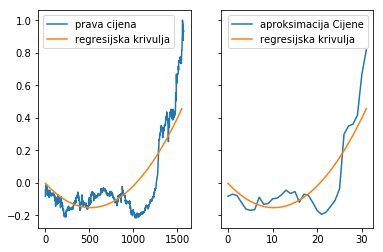

In [27]:
figRed, (axRed1, axRed2) = plt.subplots(1, 2, sharey=True)
axRed1.plot(X[:,1], cijena, label = "prava cijena")
axRed1.plot(np.multiply(Xred[:,1],50), np.dot(Xred,opt_theta), label = "regresijska krivulja")
axRed2.plot(Xred[:,1], redCijena, label = "aproksimacija Cijene")
axRed2.plot(Xred[:,1], np.dot(Xred,opt_theta), label = "regresijska krivulja")
axRed1.legend()
axRed2.legend()
figRed         

izgleda da su podatci puno bolje opisani sada nego prije, tj da preveliki broj podataka zaista uguši algoritam. 

###  2) Neuralne mreže

U ovom poglavlju kreirati ćemo jednostavnu neuralnu mrežu od 3 sloja koju ćemo koristiti kako bi klasificirali podatke u 2 skupine. Prvi sloj mreže naziva se ulazni sloj, završni sloj mreže naziva se izlazni sloj, a svi slojevi između njih nazivaju se tajni slojevi.

Naša mreža će klasificirati točke u ravnini, pa će joj ulazni sloj sadržavati 2 vrijednosti, jednu za x_1 i x_2 koordinatu. na izlazu čemo vratiti samo jednu vrijednost koja će nam govoriti kojoj klasi pripada ulazna točka. U tajnom sloju imamao slobodu koliko ćemo koristiti varijabli

Kako bi nakše generirali skup podataka za klasificiranje koristit ćemo metodu make_blobs iz sklearn biblioteke

In [28]:
from sklearn.datasets import make_blobs

In [29]:
X, y = make_blobs(n_samples=200, centers=2, cluster_std=2.0, random_state=2)
X_train, X_test, y_train, y_test = particioniranje(X,y)
y_train = y_train.reshape((140,1))
X_train.shape, y_train.shape

((140, 2), (140, 1))

X nam sadržava 200 uređenih parova a y sadržava informaciju u kojoj klasi pripada koja točka. Podjelili smo primjere na skup za treniranje i na testiranje te smo promjenili oblik y_train podataka da bi lakse radili algoritmi kasnije

moramo odrediti unaprijed parametre koliko imamo najvise ulaznih primjera u bloku, koliko imamo ulaznih parametara (broj parametara koji opisuju naše podatke, kod nas 2), broj parametara u skrivenom sloju mreže, te broj parametara na izlazu (kod nas 1, jer nam je dovoljan jedan broj koji govori kojoj klasi pripada točka). 

Unaprijed postavljamo težine u mreži na random vrijednosti. bitno je da svaki ulazni parametar ima onoliko težina koliko ima cvorova u idućem sloju jer radimo sa otpuno povezanom mrežom.

In [38]:
N, D_in, H, D_out = 140, 2, 100, 1

# Randomly initialize weights
w1 = np.random.randn(D_in, H)
w2 = np.random.randn(H, D_out)

Sada idemo istrenirati našu mrežu. algoritam treniranja je malo složeniji ali u onovi se sastoji od toga da se ulazni podatci množe odgovarajućim težinama te se prosljeđuju na idući sloj mreže. Tajni slojevi mreže još sadrže i tzv. aktivacijsku funckiju, što je kod nas, kako je i najčešće u praksi, obićna funkcija maksimuma. 
Jednom kada smo došli do kraja mreže i dobili naše predviđanje, računamo funckiju gubitka koja govori koliko smo udaljeni od prave vrijednosti. Mi ćemo koristiti sumu razlike kvadrata

Posljednji korak je algoritam propagiranja unazad, koji prenosi informaciju o grešci unazad te računa gradijente naših težina u ovisnosti o funkciji gubitka

In [39]:
learning_rate = 1e-6
for t in range(2000):
    # prolaz unaprijed
    h = X_train.dot(w1)
    h_relu = np.maximum(h, 0)
    y_pred = h_relu.dot(w2)

    # računanje i ispis odstupanja
    loss = np.square(y_pred - y_train).sum()
    if t%250 == 0 : print("t: ", t, " loss: ", loss)
    
    # propagiranje unazad 
    grad_y_pred = 2.0 * (y_pred - y_train)
    grad_w2 = h_relu.T.dot(grad_y_pred)
    grad_h_relu = grad_y_pred.dot(w2.T)
    grad_h = grad_h_relu.copy()
    grad_h[h < 0] = 0
    grad_w1 = X_train.T.dot(grad_h)

    # promjena težina
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

t:  0  loss:  888994.1035396543
t:  250  loss:  230.5805910907016
t:  500  loss:  95.99968725238189
t:  750  loss:  60.37132971215994
t:  1000  loss:  47.54836085155702
t:  1250  loss:  41.827824456147034
t:  1500  loss:  38.71715294845858
t:  1750  loss:  36.66883254950348


idemo sada vidjeti kako nam se mreža ponaša na testnom skupu. za to nam je dovoljan samo jedan forward pass 

In [40]:
h = X_test.dot(w1)
h_relu = np.maximum(h, 0)
y_pred = h_relu.dot(w2)

Sada ćemo usporediti naše podatke za predviđanje na testnom skupu sa pravim vrijednostima i time ćemo dobiti jako dobru sliku o tome koliko se dobro naša mreža ponaša generalno. Razlog tome je to što ona do sada nije vidjela podatke sa testnog skupa pa oni simuliraju još neviđene podatke

In [41]:
y_pred=(y_pred >= 0.5).astype(int)
y_pred = y_pred.reshape(60)
pogodeni= np.sum(y_pred == y_test)
accuracy = pogodeni/len(y_test)
print("postotak dobro klasificiranih testnih podataka : ",accuracy*100,"%")

postotak dobro klasificiranih testnih podataka :  73.33333333333333 %


idemo pogledati naše podatke u koordinatnom sustavu, te sa različitim bojama označiti podatke koji su bili u skupu za treniranje (crvena) i u skupu za testiranje (plava). 

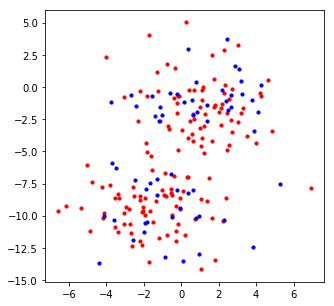

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(X_train[:, 0], X_train[:, 1], c="red", s=10)
ax.scatter(X_test[:, 0], X_test[:, 1], c="blue", s=10)

fig

vidimo da je naša podjela podataka bila reprezentativna u odnosu na polazne podatke, pa smo sada dosta sigurni da je dobivena točnost naše mreže mjerodavna. Naravno za klasifikaciju skupova dane distribucije 